## Kaggle API Setup

In [ ]:
from google.colab import files
files.upload()        # upload kaggle.json file that contains api key

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Input
from sklearn.utils import shuffle
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

 80% 65.0M/80.9M [00:00<00:00, 151MB/s]
100% 80.9M/80.9M [00:00<00:00, 149MB/s]


In [ ]:
!ls     # should have kaggle.json and sentiment140.zip
df = pd.read_csv('sentiment140.zip', encoding = 'ISO-8859-1')
df = df.iloc[:, [0,-1]]
df.columns = ['sentiment', 'tweet']
df = pd.concat([df.query("sentiment==0").sample(20000),df.query("sentiment==4").sample(20000)])   # only for colab, not enough ram

df.sentiment = df.sentiment.map({0:0, 4:1})   # 0 for negative, 1 for positive
df = shuffle(df).reset_index(drop=True)
df,df_test = train_test_split(df,test_size=0.2)   # 20% for testing, 80% for training

print(df)
print(df_test)



kaggle.json  sample_data  sentiment140.zip
       sentiment                                              tweet
7842           1  &quot;you went over so I had it shut off. Sorr...
661            0  Is tired from all the shopping.  Bought 5 thin...
37398          1  @amoyal Just another example of them not doing...
39101          0  Why can't I be like DeLeon and smile cos of th...
3196           1  @theSkillfull1 what is that, a new kind? no, n...
...          ...                                                ...
34207          1  @paul_steele you can do our lawn if you'd rather 
22438          1  Hey @patty_la sobre roy   (patty_la live &gt; ...
7013           0  @Collorious  at less it still be on cartoon ne...
4958           0  @Asharwood  I had a similar morning. somehow t...
29548          1                                      @HilaryADuff 

[32000 rows x 2 columns]
       sentiment                                              tweet
36169          1  @THEflyGIRL Wow, I agree-Guys

## Load Universal Sentence Encoder from TFhub

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed(['']).numpy().shape

def vectorize(df):       # might be limited by notebook memory
    embeded_tweets = embed(df['tweet'].values.tolist()).numpy()
    targets = df.sentiment.values
    return embeded_tweets,targets

embeded_tweets,targets = vectorize(df)


## Model

In [ ]:
model = Sequential()
model.add(Input(shape=(512,),dtype='float32'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 73985 (289.00 KB)
Trainable params: 73985 (289.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train

Epoch 1/10
900/900 [==============================] - 3s 4ms/step - loss: 0.4366 - acc: 0.7989 - val_loss: 0.4672 - val_acc: 0.7738
Epoch 2/10
900/900 [==============================] - 4s 4ms/step - loss: 0.4088 - acc: 0.8155 - val_loss: 0.4776 - val_acc: 0.7656
Epoch 3/10
900/900 [==============================] - 4s 5ms/step - loss: 0.3708 - acc: 0.8379 - val_loss: 0.4910 - val_acc: 0.7616
Epoch 4/10
900/900 [==============================] - 3s 4ms/step - loss: 0.3321 - acc: 0.8603 - val_loss: 0.5055 - val_acc: 0.7647
Epoch 5/10
900/900 [==============================] - 3s 3ms/step - loss: 0.2912 - acc: 0.8817 - val_loss: 0.5497 - val_acc: 0.7528
Epoch 6/10
900/900 [==============================] - 4s 4ms/step - loss: 0.2485 - acc: 0.9027 - val_loss: 0.6184 - val_acc: 0.7556
Epoch 7/10
900/900 [==============================] - 4s 5ms/step - loss: 0.2086 - acc: 0.9189 - val_loss: 0.6879 - val_acc: 0.7550
Epoch 8/10
900/900 [==============================] - 3s 3ms/step - loss: 0.

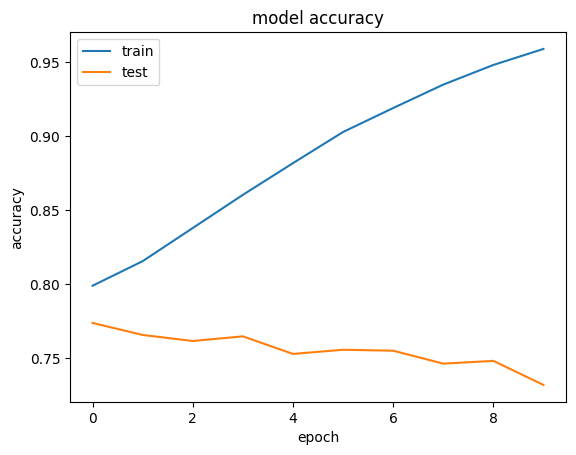

In [ ]:
num_epochs = 10
batch_size = 32   ## 2^x

history = model.fit(embeded_tweets,
                    targets,
                    epochs=num_epochs,
                    validation_split=0.1,
                    shuffle=True,
                    batch_size=batch_size)



## Show model accuracy

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


## Run model on testing set

In [ ]:
from sklearn.metrics import accuracy_score
embed_test,targets = vectorize(df_test)
predictions = model.predict(embed_test).astype(int)
accuracy_score(predictions,targets)*100

250/250 [==============================] - 1s 4ms/step


51.5125